In [1]:
%matplotlib inline
import matplotlib

In [2]:
import csv
import numpy as np
import pandas as pd
matplotlib.style.use('seaborn')
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
cubic = ["W","V","K","Al","Cu","Pd"]
hcp = ["Ti","Re","Y"]
metals = cubic+hcp
semi = ["Si"]
insul = ["NaCl"]

In [4]:
def get_mean_data_kpd(method,elements,sub_method=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different k-point density. The dataframe also
    contains the mean error per density and numbder of instances 
    the density occures.
    
    Args:
        methad (str): "Froyen", "Mueller", or "Aflow"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements:
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes:
            data = []
            kpd = []
            if sub_method is None:
                f = open("../data2/{0}/{1}_conv/{2}_atom_kpd_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data2/{0}/{1}_conv/{2}_{3}_atom_kpd_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            for row in reader:
                if float(row[0]) in kpd and float(row[1]) != 0:
                    loc = kpd.index(float(row[0]))
                    data[loc][1] = (data[loc][1]+float(row[1]))/2.
                elif float(row[1]) != 0:
                    kpd.append(float(row[0]))
                    point = [float(row[0]),float(row[1])]
                    data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                print("Method: {0}, element: {1}, size: {2}".format(method,el,i))
                
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [5]:
Fus_sc_metals = get_mean_data_kpd("Froyen",["W","K","Al","Cu","Pd"],sub_method="sc")
Fus_bcc_metals = get_mean_data_kpd("Froyen",["W","K","Al","Cu","Pd"],sub_method="bcc")
Fus_fcc_metals = get_mean_data_kpd("Froyen",["W","K","Al","Cu","Pd"],sub_method="fcc")

In [6]:
Fus_sc_mean = np.transpose([Fus_sc_metals.index.values,Fus_sc_metals["mean"]])
Fus_bcc_mean = np.transpose([Fus_bcc_metals.index.values,Fus_bcc_metals["mean"]])
Fus_fcc_mean = np.transpose([Fus_fcc_metals.index.values,Fus_fcc_metals["mean"]])
Fus_mean = np.concatenate((Fus_sc_mean,Fus_bcc_mean,Fus_fcc_mean),axis=0)

In [7]:
Fv_sc_metals = get_mean_data_kpd("Froyen_VASP",["W","K","Al","Cu","Pd"],sub_method="sc")
Fv_bcc_metals = get_mean_data_kpd("Froyen_VASP",["W","K","Al","Cu","Pd"],sub_method="bcc")
Fv_fcc_metals = get_mean_data_kpd("Froyen_VASP",["W","K","Al","Cu","Pd"],sub_method="fcc")

In [8]:
Fv_sc_mean = np.transpose([Fv_sc_metals.index.values,Fv_sc_metals["mean"]])
Fv_bcc_mean = np.transpose([Fv_bcc_metals.index.values,Fv_bcc_metals["mean"]])
Fv_fcc_mean = np.transpose([Fv_fcc_metals.index.values,Fv_fcc_metals["mean"]])
Fv_mean = np.concatenate((Fv_sc_mean,Fus_bcc_mean,Fv_fcc_mean),axis=0)

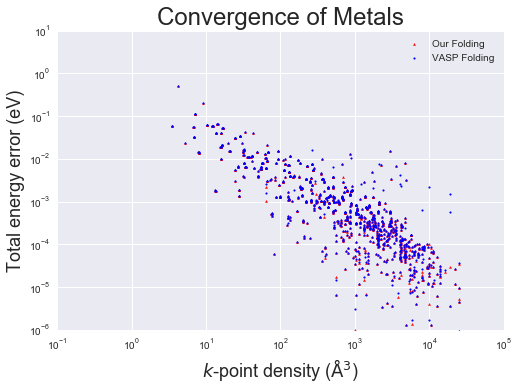

In [40]:
plt.scatter(Fus_mean[:,0],abs(Fus_mean[:,1]),label="Our Folding",marker="^",s=5,c='r')
plt.scatter(Fv_mean[:,0],abs(Fv_mean[:,1]),label="VASP Folding",marker="o",s=3,c='b')
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.xlabel("$k$-point density ($\mathrm{\AA}^{3}$)",fontsize=18)
plt.title("Convergence of Metals",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,1E1)
plt.xlim(1E-1,1E5)
plt.legend()
plt.savefig("/Users/wileymorgan/Desktop/No_V.pdf")
plt.show()

In [9]:
def histogram(us,vasp):
    result = []
    for i in range(len(us)):
        for j in range(len(vasp)):
            if np.allclose(us[i,0], vasp[j,0]):
                result.append(vasp[j,1]-us[i,1])
                break
    return result

In [10]:
hist = histogram(Fus_mean,Fv_mean)

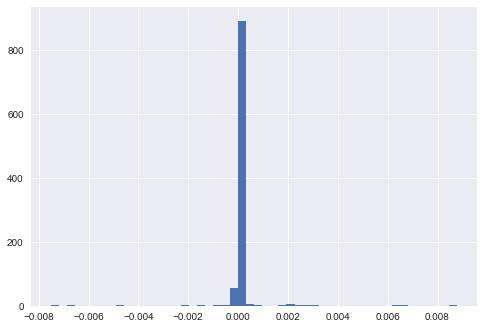

In [41]:
n, bins, patches = plt.hist(hist,50)
delta = bins[1]-bins[0]
bins = np.array(bins)
bins = bins-delta/2

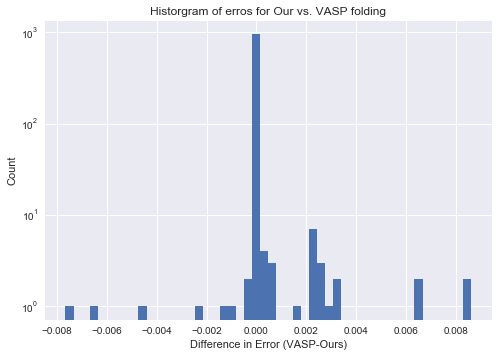

In [42]:
plt.hist(hist,bins)
plt.yscale('log', nonposy='clip')
plt.title("Historgram of erros for Our vs. VASP folding")
plt.xlabel("Difference in Error (VASP-Ours)")
plt.ylabel("Count")
plt.savefig("../plots/FOLDING_US_VASP_HIST.pdf")
plt.show()

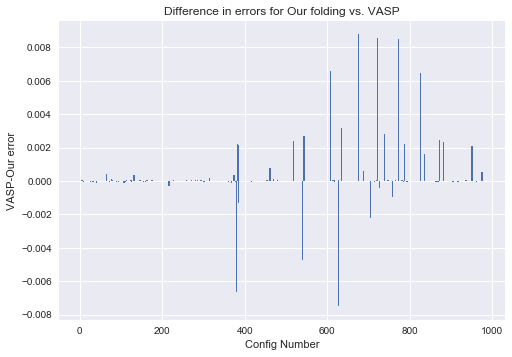

In [72]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(hist)),hist,width=3)
plt.title("Difference in errors for Our folding vs. VASP")
plt.xlabel("Config Number")
plt.ylabel("VASP-Our error")
plt.savefig("/Users/wileymorgan/Desktop/Error_Historgram.pdf")
plt.show()